In [ ]:
import pandas as pd

# Load the n-gram CSVs with smoothing already computed
unigram_df = pd.read_csv("unigram.csv")
bigram_df = pd.read_csv("bigram.csv")
trigram_df = pd.read_csv("trigram.csv")
quadrigram_df = pd.read_csv("quadrigram.csv")

print("Unigram sample:")
display(unigram_df.head())

Unigram sample:


,Ngram,Raw,Add-One,Add-K,Token-Type
0,<s>,0.047601,0.047224,0.047374,0.000009
1,</s>,0.047601,0.047224,0.047374,0.000009
2,।,0.037242,0.036947,0.037065,0.000007
3,के,0.034319,0.034047,0.034156,0.000007
4,में,0.026106,0.025900,0.025982,0.000005


In [4]:
import random, re

bbc_df = pd.read_csv("bbc_hindi_articles_with_categories_cleaned.csv")

sentences = []
for text in bbc_df['Content'].dropna().tolist():
    # Keep punctuation with sentence using regex
    sents = re.findall(r'[^।.!?]+[।.!?]', text)

    # Clean + add <s> </s>
    sents = [f"<s> {s.strip()} </s>" for s in sents if len(s.strip()) > 0]
    sentences.extend(sents)

# Randomly pick 1000 sentences for evaluation
random.seed(42)
sampled_sentences = random.sample(sentences, min(1000, len(sentences)))

print("Total sampled sentences:", len(sampled_sentences))
print("Example sentence:", sampled_sentences[0])

Total sampled sentences: 1000
Example sentence: <s> नामांकन दाखिल करने के बाद समाचार एजेंसी एएनआई से अमित शाह ने कहा, ''इस सीट से ही मैंने बूथ कार्यकर्ता से लेकर संसद तक का सफर तय किया है. </s>


In [5]:
import numpy as np

def sentence_logprob(sentence, model, smoothing='Add-One'):
    """
    Compute log probability of a sentence using a given n-gram model.
    
    sentence: str
    model: DataFrame with columns [Ngram, Raw, Add-One, Add-K, Token-Type]
    smoothing: which probability column to use
    """
    tokens = sentence.split()
    log_prob = 0.0
    
    # detect n directly from one Ngram string in the model
    n = len(model.iloc[0]['Ngram'].split())
    
    for i in range(len(tokens)):
        if i+1 < n:
            continue
        ngram = ' '.join(tokens[i-n+1:i+1])
        row = model[model['Ngram'] == ngram]
        
        if row.empty:
            log_prob += np.log(1e-12)  # unseen n-gram fallback
        else:
            p = row.iloc[0][smoothing]
            log_prob += np.log(p if p > 0 else 1e-12)
    
    return log_prob


In [6]:
results = []
for s in sampled_sentences[:10]:
    res = {
        'Sentence': s,
        'Unigram_AddOne': sentence_logprob(s, unigram_df, 'Add-One'),
        'Bigram_AddOne': sentence_logprob(s, bigram_df, 'Add-One'),
        'Trigram_AddOne': sentence_logprob(s, trigram_df, 'Add-One'),
        'Quadrigram_AddOne': sentence_logprob(s, quadrigram_df, 'Add-One')
    }
    results.append(res)

pd.DataFrame(results)


,Sentence,Unigram_AddOne,Bigram_AddOne,Trigram_AddOne,Quadrigram_AddOne
0,<s> नामांकन दाखिल करने के बाद समाचार एजेंसी एए...,-283.494476,-468.914086,-629.087946,-674.253702
1,<s> इनमें एक उनका नाम भी है. </s>,-67.852786,-126.949811,-148.321889,-138.155106
2,<s> फ़िल्म एक ढर्रे पर चल रही होती है तभी एक घ...,-256.677240,-532.009081,-708.621521,-732.548887
3,<s> मर्दाना ट्रोल समाज असल में दीपिका की बात स...,-116.927159,-233.665598,-286.861747,-276.310211
4,<s> जिन छात्रों को खाने की चीज़ों या किसी और च...,-220.257028,-417.911617,-536.715152,-593.337731
5,"<s> "" “कुछ समय पहले जब मैं समरकंद में\nराष्ट्र...",-239.397181,-445.942542,-642.479303,-703.985047
6,<s> घरेलू हिंसा के दायरे को समझना और उससे घरों...,-131.977443,-232.342480,-312.228054,-331.572253
7,"<s> "" वे दावा करते हैं, ""इसी बीच यहां के स्थान...",-315.286313,-567.515313,-742.654689,-746.037570
8,"<s> "" इस खदान की सुरक्षा के लिए इंडोनेशिया के ...",-299.451346,-603.037569,-814.003676,-897.558547
9,<s> यानी छात्रों के पास परीक्षा देने के लिए कं...,-203.757083,-403.574762,-496.274979,-537.684823


In [7]:
final_results = []
for s in sampled_sentences:
    res = {'Sentence': s}
    for model_name, model in [('Unigram', unigram_df),
                              ('Bigram', bigram_df),
                              ('Trigram', trigram_df),
                              ('Quadrigram', quadrigram_df)]:
        for smoothing in ['Add-One','Add-K','Token-Type']:
            key = f"{model_name}_{smoothing}"
            res[key] = sentence_logprob(s, model, smoothing)
    final_results.append(res)

final_df = pd.DataFrame(final_results)
final_df.to_csv("sentence_logprobabilities.csv", index=False)
final_df.head()



,Sentence,Unigram_Add-One,Unigram_Add-K,Unigram_Token-Type,Bigram_Add-One,Bigram_Add-K,Bigram_Token-Type,Trigram_Add-One,Trigram_Add-K,Trigram_Token-Type,Quadrigram_Add-One,Quadrigram_Add-K,Quadrigram_Token-Type
0,<s> नामांकन दाखिल करने के बाद समाचार एजेंसी एए...,-283.494476,-283.407134,-451.112960,-468.914086,-468.875075,-519.812228,-629.087946,-624.016255,-686.228012,-674.253702,-670.745368,-701.494165
1,<s> इनमें एक उनका नाम भी है. </s>,-67.852786,-67.830634,-117.679788,-126.949811,-126.938728,-137.266613,-148.321889,-147.812891,-154.279084,-138.155106,-138.155106,-138.155106
2,<s> फ़िल्म एक ढर्रे पर चल रही होती है तभी एक घ...,-256.677240,-256.593063,-422.398123,-532.009081,-531.986307,-562.609647,-708.621521,-706.597703,-727.640497,-732.548887,-732.054869,-735.726939
3,<s> मर्दाना ट्रोल समाज असल में दीपिका की बात स...,-116.927159,-116.896345,-182.951570,-233.665598,-233.651267,-247.325156,-286.861747,-286.354742,-292.434202,-276.310211,-276.310211,-276.310211
4,<s> जिन छात्रों को खाने की चीज़ों या किसी और च...,-220.257028,-220.186438,-357.932490,-417.911617,-417.880085,-452.544085,-536.715152,-533.674025,-566.471310,-593.337731,-592.832721,-597.571832


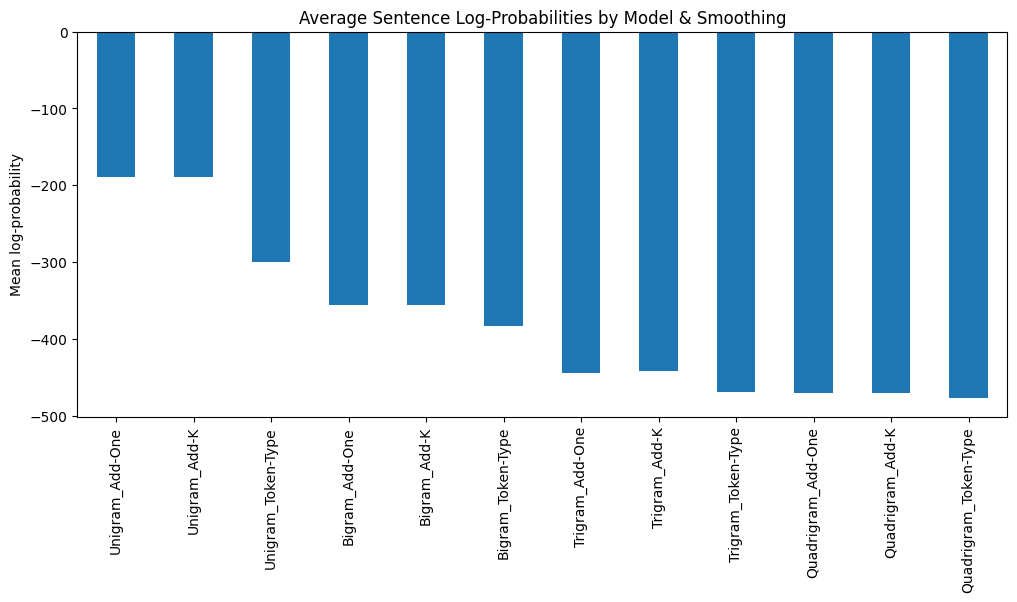

In [8]:
import matplotlib.pyplot as plt

avg_log_probs = final_df.drop(columns=['Sentence']).mean()

avg_log_probs.plot(kind="bar", figsize=(12,5))
plt.title("Average Sentence Log-Probabilities by Model & Smoothing")
plt.ylabel("Mean log-probability")
plt.show()
